# V928 Tau - Eclipse Model Comparisons

In this notebook we take the output of the stellar variation notebook and model the eclipse. We do this using the <strong>pyPplusS</strong> package designed by Rein & Odir 2019. We make the assumption that the two components of the binary are identical and thus that the deblended light curve just doubles the fluctuations about 1. Here we compare the different eclipse models investigated.

In [1]:
import emcee
import logging
import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from Code import mcmc, eclipse

%matplotlib inline

## Load the Data

In [2]:
time, flux_b, flux, error = eclipse.load_data('data/photometry/eclipse_lightcurve.txt')

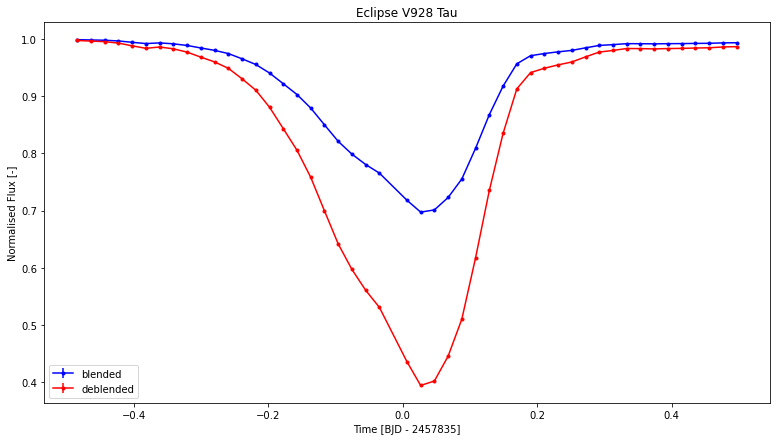

In [3]:
plt.figure(figsize=(13, 7))
plt.title('Eclipse V928 Tau')
plt.xlabel('Time [BJD - 2457835]')
plt.ylabel('Normalised Flux [-]')
plt.errorbar(time, flux_b, yerr=error, fmt='.', color='b', ls='-', label='blended')
plt.errorbar(time, flux, yerr=error, fmt='.', color='r', ls='-', label='deblended')
plt.legend()
plt.show()

## Model Set-up

This takes the <strong>disk_model()</strong> function from <strong>eclipse_functions</strong>, and creates sub-functions for:

* fuzzy_disk --> n.a.
* translucent_disk --> redge = 0, tau_edge = 0
* opaque_disk --> redge = 0, tau_edge = 0, tau_disk = 0

In [4]:
# packing functions
pack_td = lambda rd, b, inc, tilt, vel, dx, taud: (rd, 0., b, inc, tilt, vel, dx, taud, 0.)
pack_od = lambda rd, b, inc, tilt, vel, dx: (rd, 0., b, inc, tilt, vel, dx, 1., 0.)

# all the disk model variants
fuzzy_disk       = eclipse.disk_model
translucent_disk = lambda P, time: eclipse.disk_model(pack_td(*P), time)
opaque_disk      = lambda P, time: eclipse.disk_model(pack_od(*P), time)

# all the disk prior variants
fuzzy_prior       = eclipse.disk_prior
translucent_prior = lambda P: eclipse.disk_prior(pack_td(*P))
opaque_prior      = lambda P: eclipse.disk_prior(pack_od(*P))


In [5]:
# Bounds of the parameters (t = tilt, T = tau, rest as above)
rl, ru = (0., 10.)
bl, bu = (-10.,10.)
il, iu = (0., np.pi/2.)
tl, tu = (0., np.pi/2.)
vl, vu = (5.9, 20.)
xl, xu = (-10.,10.)
Tl, Tu = (0.,1.)

## Opaque Disk

The opaque disk model has $r_\mathrm{edge} = 0, \ \tau_\mathrm{edge} = 0, \ \tau_\mathrm{disk} = 1$.

In [6]:
# setting the the parameter names, units and bounds
lbls_od = ['disk radius', 'impact parameter', 'inclination', 'tilt', 'velocity', 'time shift']
units_od = ['R*', 'R*', 'deg', 'deg', 'R*/day', 'day']

We extract the best fit parameters from the npy files.

In [7]:
# extract best fits
pb_hvel_od = np.load('models/best_fits/opaque_disk_high_velocity.npy')
pb_ldr_od  = np.load('models/best_fits/opaque_disk_low_velocity_small_disk.npy')

We extract the sampler from the backend

In [8]:
# mcmc parameters for opaque disk
be_od = 'models/mcmc_backends/opaque_disk.h5'
args_od = (time, flux, error, opaque_disk, opaque_prior)
BE_od = emcee.backends.HDFBackend(be_od)

# load mcmc for opaque disk
sampler_od = emcee.EnsembleSampler(1000, 6, mcmc.lnprob, args=args_od, backend=BE_od)

We extract the partial solutions for the samplers. These are the high velocity ($v_t > 8 \, R_*\,\mathrm{day}^{-1}$) and the low velocity, small disk radii ($v_t < 8 \, R_*\,\mathrm{day}^{-1} \ ; \ r_\mathrm{disk} < 1.5 \, R_*$) solutions.

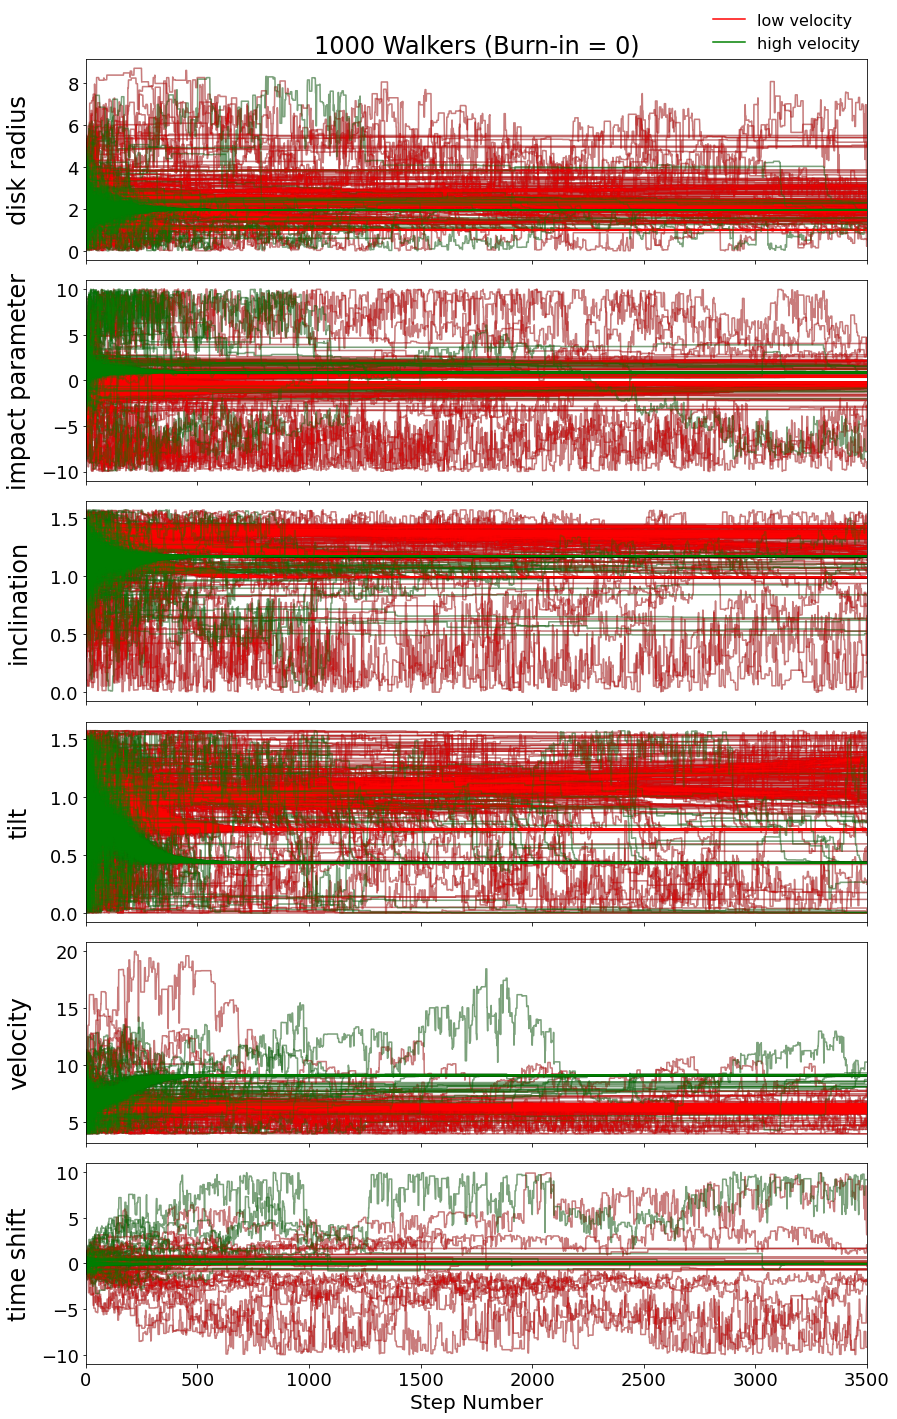

In [9]:
# extracting the low and high velocity solutions for the opaque disk
vel_names_od = ['low velocity', 'high velocity']
lvel_od, hvel_od = mcmc.extract_solutions(sampler_od, [4, 4], [(0, 8), (8, 20)], 0, lbls_od, vel_names_od)


In [10]:
# deciding the burn-in for the high velocity solutions for the opaque disk
cut_hvel_od = 500

# carrying out statistics for the high velocity solutions for the opaque disk
stats_hvel_od, pb_hvel_od = mcmc.stats(hvel_od, cut=cut_hvel_od)

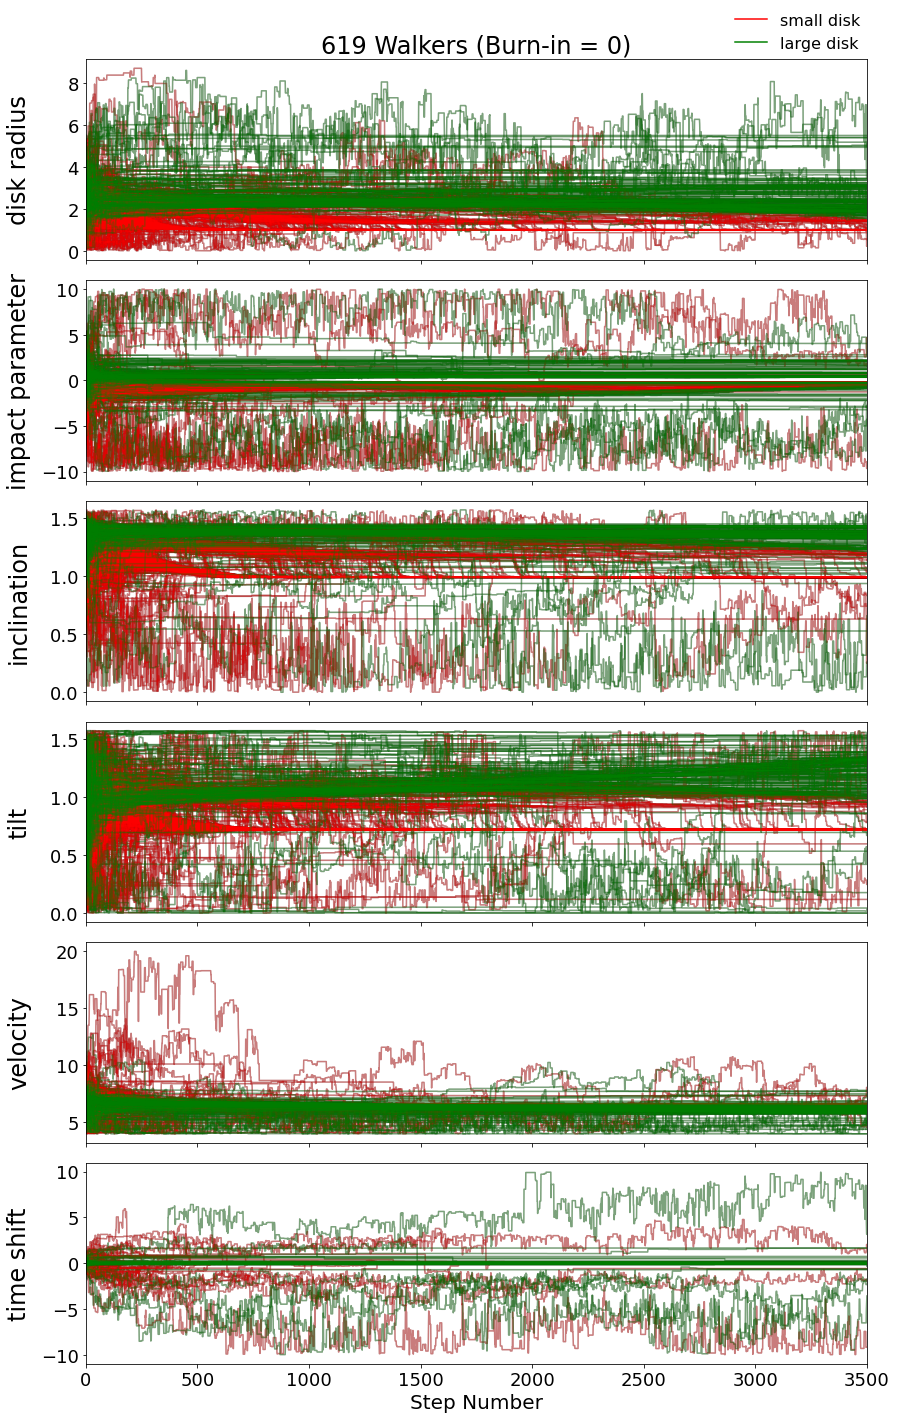

In [11]:
# extract low velocity disk radii solutions for the opaque disk
dr_names_od = ['small disk', 'large disk']
ldr_od, hdr_od = mcmc.extract_solutions(lvel_od, [0, 0], [(0, 1.5), (1.5, 20)], 0, lbls_od, dr_names_od)

In [12]:
# determining the burn-in for the low velocity low disk radii solutions for the opaque disk
cut_ldr_od = 1000

# carrying out statistics for the low velocity low disk radii solutions for the opaque disk
stats_ldr_od, pb_ldr_od = mcmc.stats(ldr_od, cut=cut_ldr_od)

## Translucent Disk

The translucent disk model has $r_\mathrm{edge} = 0, \ \tau_\mathrm{edge} = 0$.

In [13]:
# Set up parameter labels, units and bounds for the translucent disk
lbls_td = ['disk radius', 'impact parameter', 'inclination', 'tilt', 'velocity', 'time shift', 'disk opacity']
units_td = ['R*', 'R*', 'deg', 'deg', 'R*/day', 'day', '-']

We extract the best fit parameters from the npy files.

In [14]:
# extract best fits
pb_hvel_td = np.load('models/best_fits/translucent_disk_high_velocity.npy')
pb_ldr_td  = np.load('models/best_fits/translucent_disk_low_velocity_small_disk.npy')

We extract the sampler from the backend

In [15]:
# mcmc parameters for the translucent disk
be_td = 'models/mcmc_backends/translucent_disk.h5'
args_td = (time, flux, error, translucent_disk, translucent_prior)
BE_td = emcee.backends.HDFBackend(be_td)

# load mcmc for the translucent disk
sampler_td = emcee.EnsembleSampler(1000, 7, mcmc.lnprob, args=args_td, backend=BE_td)

We extract the partial solutions for the samplers. These are the high velocity ($v_t > 8 \, R_*\,\mathrm{day}^{-1}$) and the low velocity, small disk radii ($v_t < 8 \, R_*\,\mathrm{day}^{-1} \ ; \ r_\mathrm{disk} < 2.0 \, R_*$) solutions.

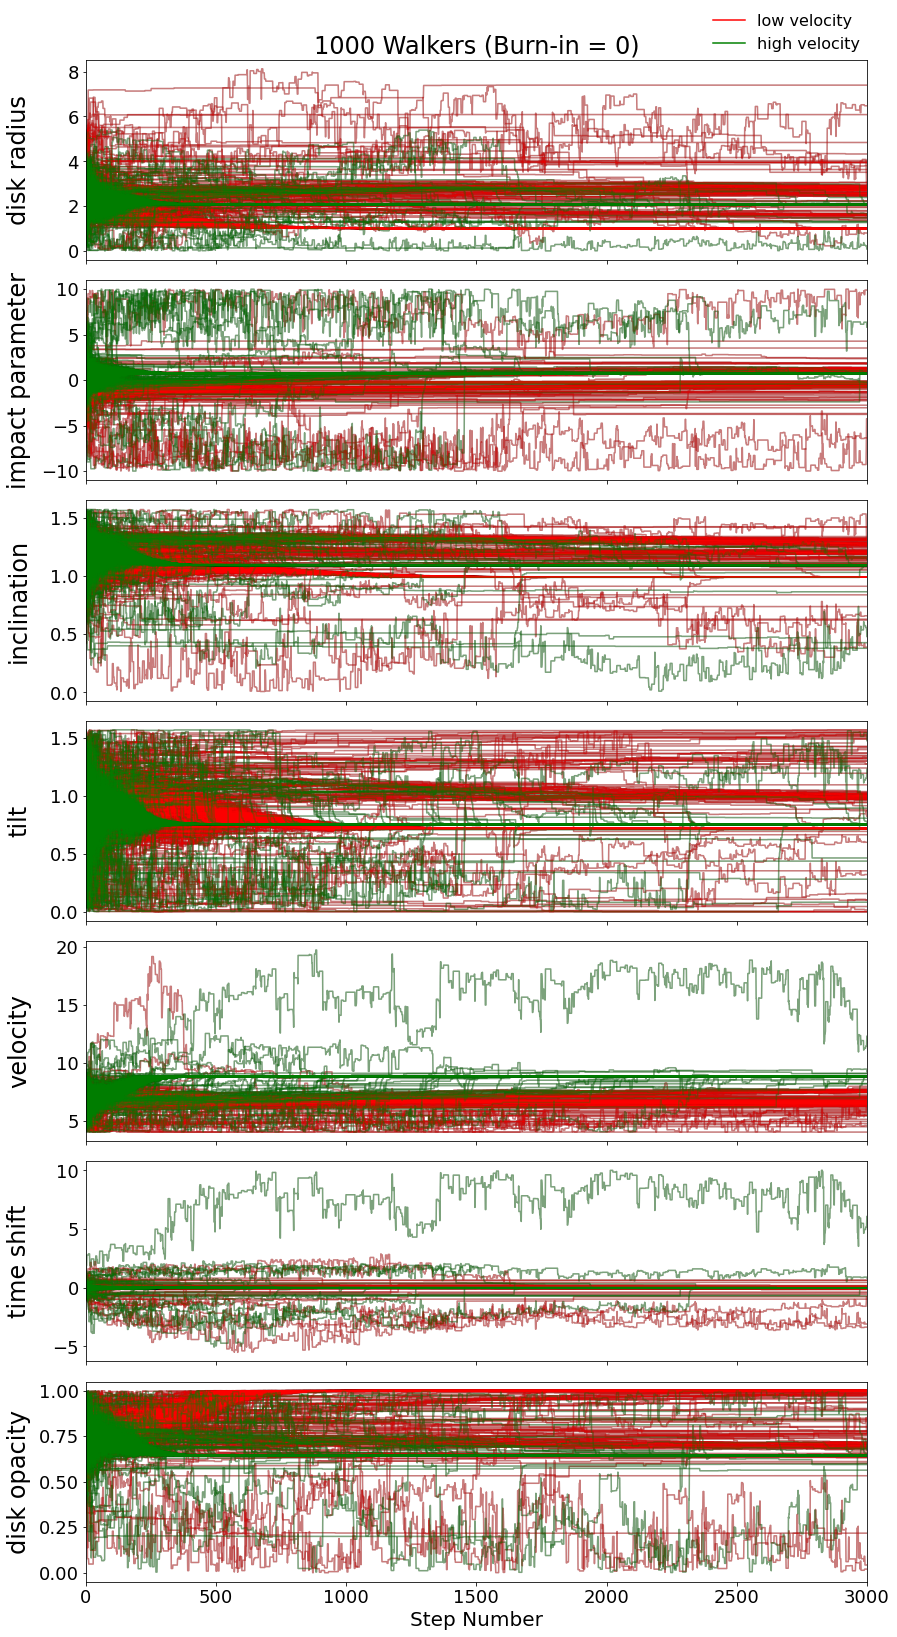

In [16]:
# extracting low and high velocity solutions for the translucent disk
vel_names_td = ['low velocity', 'high velocity']
lvel_td, hvel_td = mcmc.extract_solutions(sampler_td, [4, 4], [(0, 8), (8, 20)], 0, lbls_td, vel_names_td)

In [17]:
# determine the burn-in for the high velocity solutions for the translucent disk
cut_hvel_td = 500

# carry out statistics for the high velocity solutions for the translucent disk
stats_hvel_td, _ = mcmc.stats(hvel_td, cut=cut_hvel_td)

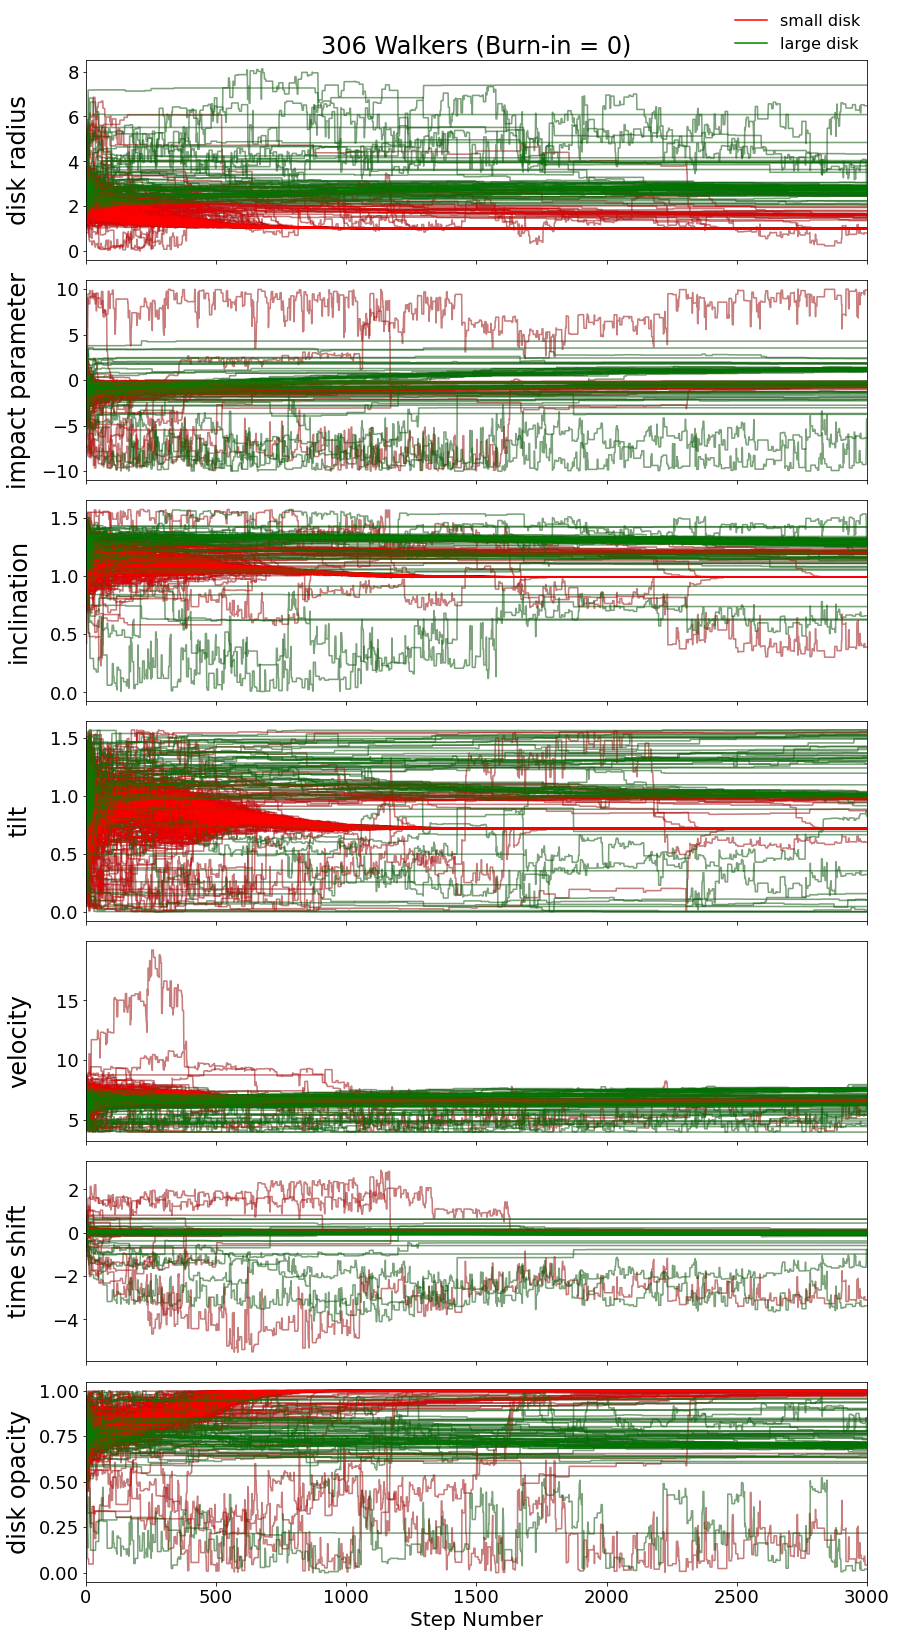

In [18]:
# extracting disk radius for the low velocity solutions of the translucent disk
dr_names_td = ['small disk', 'large disk']
ldr_td, hdr_td = mcmc.extract_solutions(lvel_td, [0, 0], [(0, 2), (2, 20)], 0, lbls_td, dr_names_td)

In [19]:
# determine the burn-in for the low velocity low disk radii solutions for the translucent disk
cut_ldr_td = 500

# carry out statistics for the low velocity low disk radii solutions for the translucent disk
stats_ldr_td, _ = mcmc.stats(ldr_td, cut=cut_ldr_td)

## Compare Single Component Disks (Opaque and Translucent)

Here we compare the solutions for the Opaque Disk and the Translucent Disk

/Users/dmvandam/SurfDrive/phd/github/v928tau/pyPplusS/segment_models.py:452: RuntimeWarning: invalid value encountered in less
  todo_start = np.all(np.logical_or(splitr[:,2:]<rcrit,np.isnan(splitr[:,2:])),-1)
/Users/dmvandam/SurfDrive/phd/github/v928tau/pyPplusS/segment_models.py:452: RuntimeWarning: invalid value encountered in less
  todo_start = np.all(np.logical_or(splitr[:,2:]<rcrit,np.isnan(splitr[:,2:])),-1)
/Users/dmvandam/SurfDrive/phd/github/v928tau/pyPplusS/segment_models.py:452: RuntimeWarning: invalid value encountered in less
  todo_start = np.all(np.logical_or(splitr[:,2:]<rcrit,np.isnan(splitr[:,2:])),-1)
/Users/dmvandam/SurfDrive/phd/github/v928tau/pyPplusS/segment_models.py:452: RuntimeWarning: invalid value encountered in less
  todo_start = np.all(np.logical_or(splitr[:,2:]<rcrit,np.isnan(splitr[:,2:])),-1)


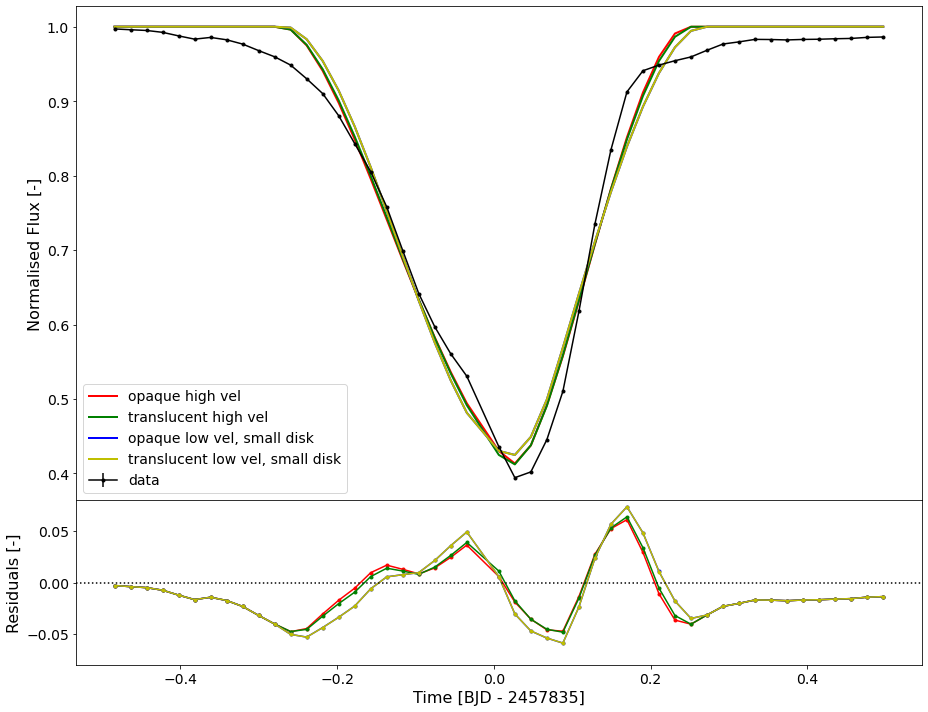

In [20]:
tod_mods = 2 * [opaque_disk, translucent_disk]
tod_lbls = ['opaque high vel', 'translucent high vel',
            'opaque low vel, small disk', 'translucent low vel, small disk']
tod_pbs  = [pb_hvel_od, pb_hvel_td, pb_ldr_od, pb_ldr_td]

tod_chi2 = mcmc.plot_models(time, flux, error, tod_mods, tod_pbs, tod_lbls, dt=3002, residual_lims=(-0.08, 0.08),
                            lw=2)

In [21]:
tod_disk  = 2 * ['opaque', 'translucent']
tod_type  = 2 * ['high velocity'] + 2 * ['low velocity, small disk']
tod_lbls  = 2 * [lbls_od, lbls_td]
tod_units = 2 * [units_od, units_td]


for disk, typ, pb, chi2, lbl, unit in zip(tod_disk, tod_type, tod_pbs, tod_chi2, tod_lbls, tod_units):
    #print(disk, typ, pb, chi2, lbl, unit)
    print('%s disk with %s' % (disk, typ))
    mcmc.print_parameters(pb, lbl, unit)
    print('chi2 = %.2f' % chi2)
    print('')

opaque disk with high velocity
disk radius        =     +1.939238     [R*]
impact parameter   =     +0.851913     [R*]
inclination        =     +67.11369     [deg]
tilt               =     +24.83339     [deg]
velocity           =     +9.135350     [R*/day]
time shift         =     -0.058551     [day]
chi2 = 2682609.33

translucent disk with high velocity
disk radius        =     +2.071857     [R*]
impact parameter   =     +0.722407     [R*]
inclination        =     +62.47948     [deg]
tilt               =     +43.23963     [deg]
velocity           =     +8.826365     [R*/day]
time shift         =     -0.046670     [day]
disk opacity       =     +0.643868     [-]
chi2 = 2753221.61

opaque disk with low velocity, small disk
disk radius        =     +0.992294     [R*]
impact parameter   =     -0.250570     [R*]
inclination        =     +56.78165     [deg]
tilt               =     +41.21967     [deg]
velocity           =     +6.636696     [R*/day]
time shift         =     +0.009899     [da

Interestingly enough the parameters are quite comparable for the high velocity and the low velocity solutions, but in both cases the opaque disk has a better goodness of fit. For this reason we adopt these values.

## Fuzzy Disk

The fuzzy disk is a two component disk model which is ended to have an opaque centre (as above) and then an extended edge that is expected to be relatively transparent.

In [22]:
# setting up labels, units and bounds for the fuzzy disk
lbls_fd = ['disk radius', 'edge thickness', 'impact parameter', 'inclination', 'tilt', 
           'velocity', 'time shift', 'disk opacity', 'edge opacity']
units_fd = ['R*', 'R*', 'R*', 'deg', 'deg', 'R*/day', 'day', '-', '-']

We extract the best fit parameters from the npy files.

In [23]:
# extract best fits
pb_hvel_fd = np.load('models/best_fits/fuzzy_high_vel_disk.npy')
pb_lvel_fd  = np.load('models/best_fits/fuzzy_low_vel_disk.npy')

We extract the samplers from the backends.

In [24]:
# mcmc parameters for the fuzzy disk
be_fd = 'models/mcmc_backends/fuzzy_disk_new.h5'
mcmc_args_fd = (time, flux, error, fuzzy_disk, fuzzy_prior)
BE_fd = emcee.backends.HDFBackend(be_fd)

# load mcmc for the fuzzy disk
sampler_fd = emcee.EnsembleSampler(1000, 9, mcmc.lnprob, args=mcmc_args_fd, backend=BE_fd)

Here we extract solutions with velocities below and above 8.5 $R_* \, \mathrm{day}^{-1}$.

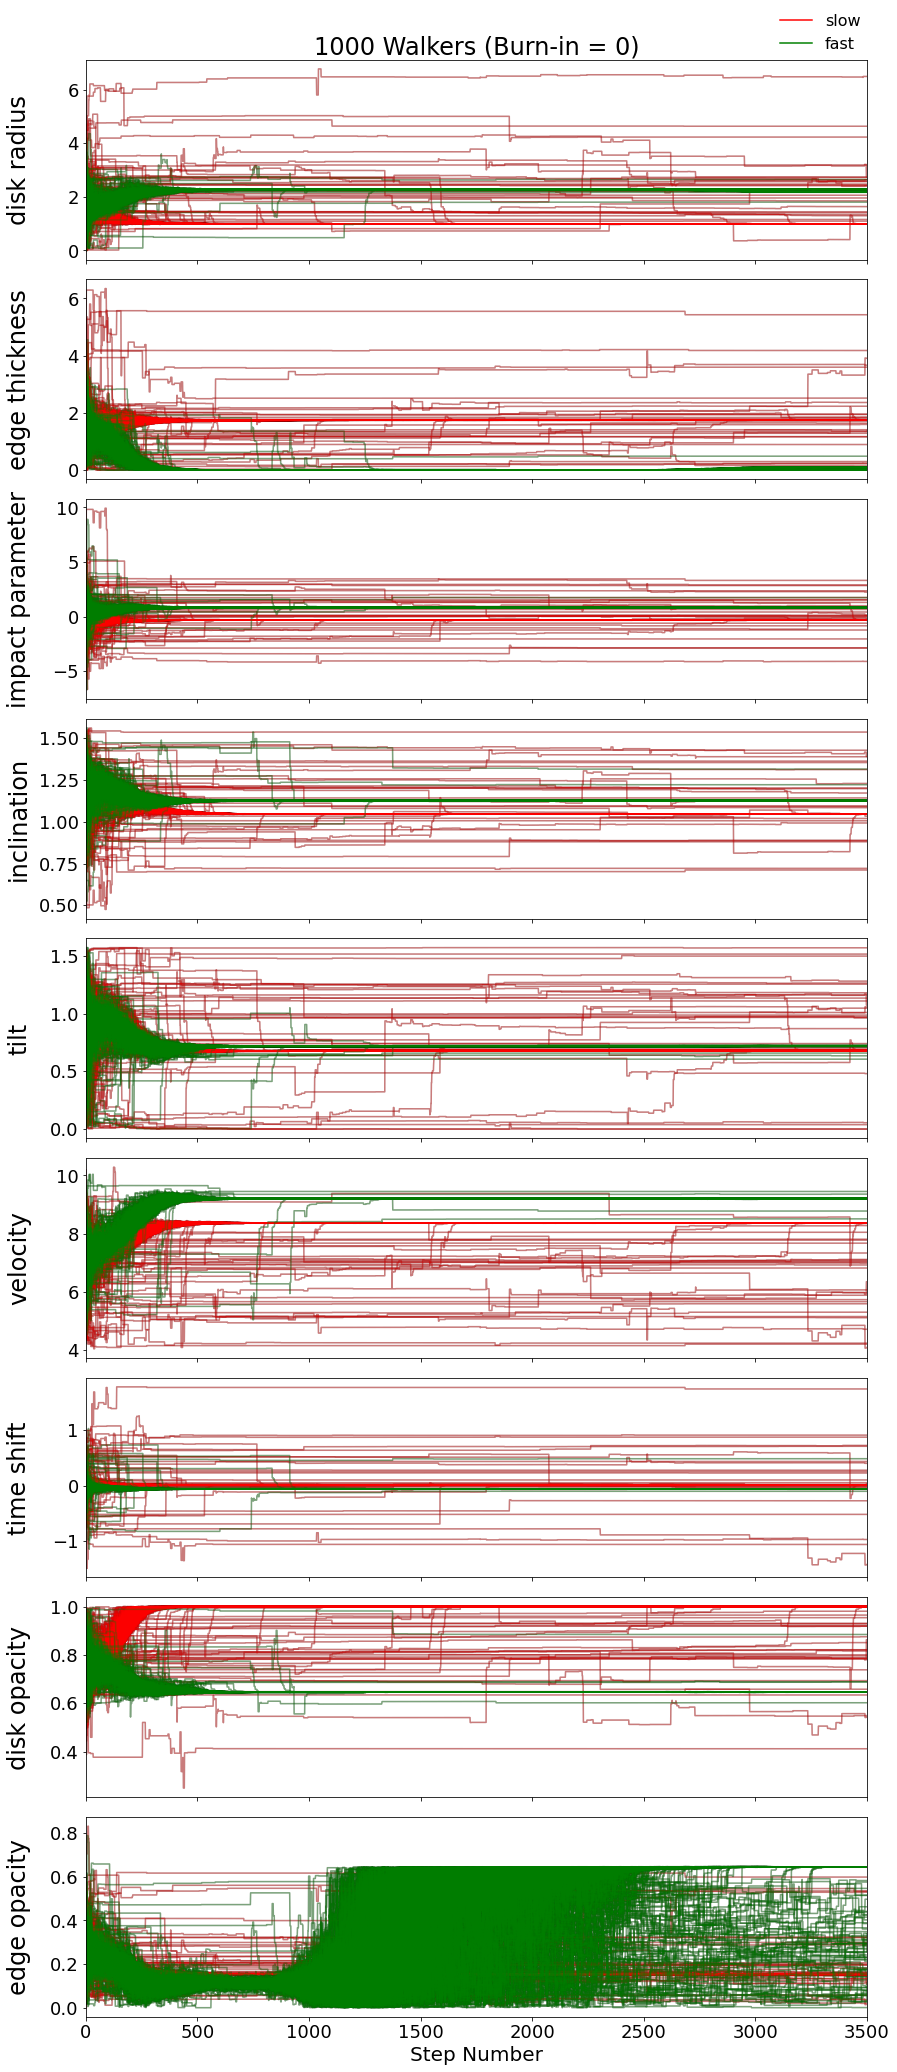

In [25]:
# extracting disk opacity radius for the fuzzy disk
v_names_fd = ['slow', 'fast']
vl_fd, vh_fd  = mcmc.extract_solutions(sampler_fd, [5, 5], [(0., 8.5), (8.5, 20.)],
                                                0, lbls_fd, v_names_fd)

In [26]:
# determine burn-in for the high velocity solutions for the fuzzy disk
cut_vh_fd = 2500

# carry out statistics for the high velocity solutions for the fuzzy disk
stats_vh_fd, _ = mcmc.stats(vh_fd, cut=cut_vh_fd)

In [27]:
# determine burn-in for the low velocity solutions for the fuzzy disk
cut_vl_fd = 1000

# carry out statistics for the low velocity solutions for the fuzzy disk
stats_vl_fd, _ = mcmc.stats(vl_fd, cut=cut_vl_fd)

### Compare Fuzzy Disk Solutions

/Users/dmvandam/SurfDrive/phd/github/v928tau/pyPplusS/segment_models.py:452: RuntimeWarning: invalid value encountered in less
  todo_start = np.all(np.logical_or(splitr[:,2:]<rcrit,np.isnan(splitr[:,2:])),-1)
/Users/dmvandam/SurfDrive/phd/github/v928tau/pyPplusS/segment_models.py:452: RuntimeWarning: invalid value encountered in less
  todo_start = np.all(np.logical_or(splitr[:,2:]<rcrit,np.isnan(splitr[:,2:])),-1)


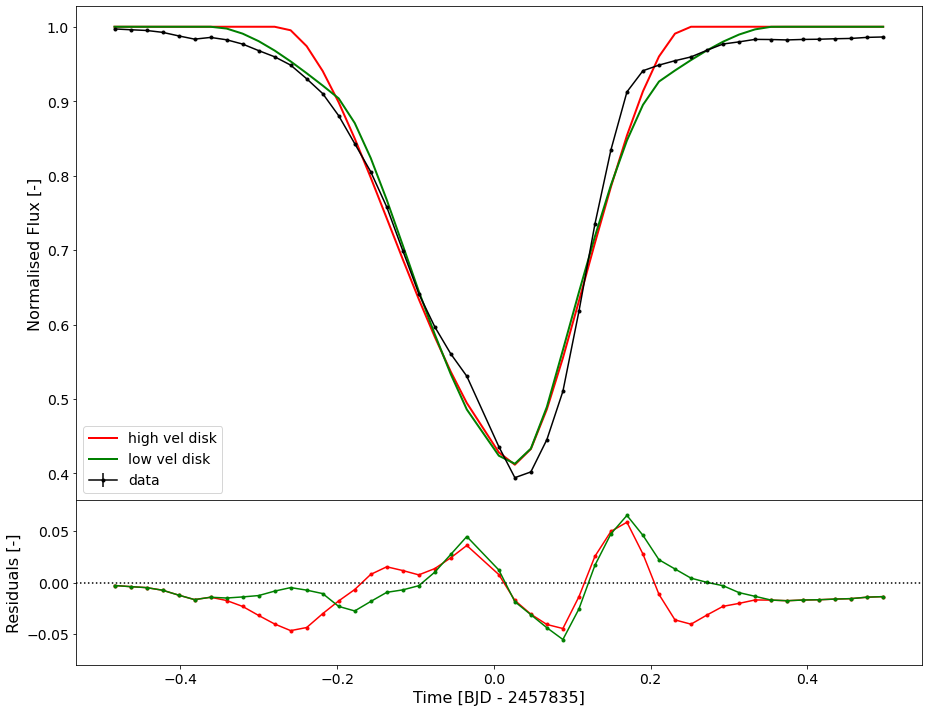

In [28]:
chi2s_fd = mcmc.plot_models(time, flux, error, 2*[fuzzy_disk], [pb_hvel_fd, pb_lvel_fd], 
                     ['high vel disk', 'low vel disk'], dt=3002, residual_lims=(-0.08, 0.08), lw=2)

In [29]:
print('chi2 for the fuzzy disk with a high velocity disk is - %.6f' % chi2s_fd[0])
print('chi2 for the fuzzy disk with a low velocity disk is  - %.6f' % chi2s_fd[1])

chi2 for the fuzzy disk with a high velocity disk is - 2512743.791566
chi2 for the fuzzy disk with a low velocity disk is  - 1982370.745709


## Compare All Disk Models

Here we compare all the disk models we've tested against each other and present the results below.

/Users/dmvandam/SurfDrive/phd/github/v928tau/pyPplusS/segment_models.py:452: RuntimeWarning: invalid value encountered in less
  todo_start = np.all(np.logical_or(splitr[:,2:]<rcrit,np.isnan(splitr[:,2:])),-1)
/Users/dmvandam/SurfDrive/phd/github/v928tau/pyPplusS/segment_models.py:452: RuntimeWarning: invalid value encountered in less
  todo_start = np.all(np.logical_or(splitr[:,2:]<rcrit,np.isnan(splitr[:,2:])),-1)
/Users/dmvandam/SurfDrive/phd/github/v928tau/pyPplusS/segment_models.py:452: RuntimeWarning: invalid value encountered in less
  todo_start = np.all(np.logical_or(splitr[:,2:]<rcrit,np.isnan(splitr[:,2:])),-1)
/Users/dmvandam/SurfDrive/phd/github/v928tau/pyPplusS/segment_models.py:452: RuntimeWarning: invalid value encountered in less
  todo_start = np.all(np.logical_or(splitr[:,2:]<rcrit,np.isnan(splitr[:,2:])),-1)


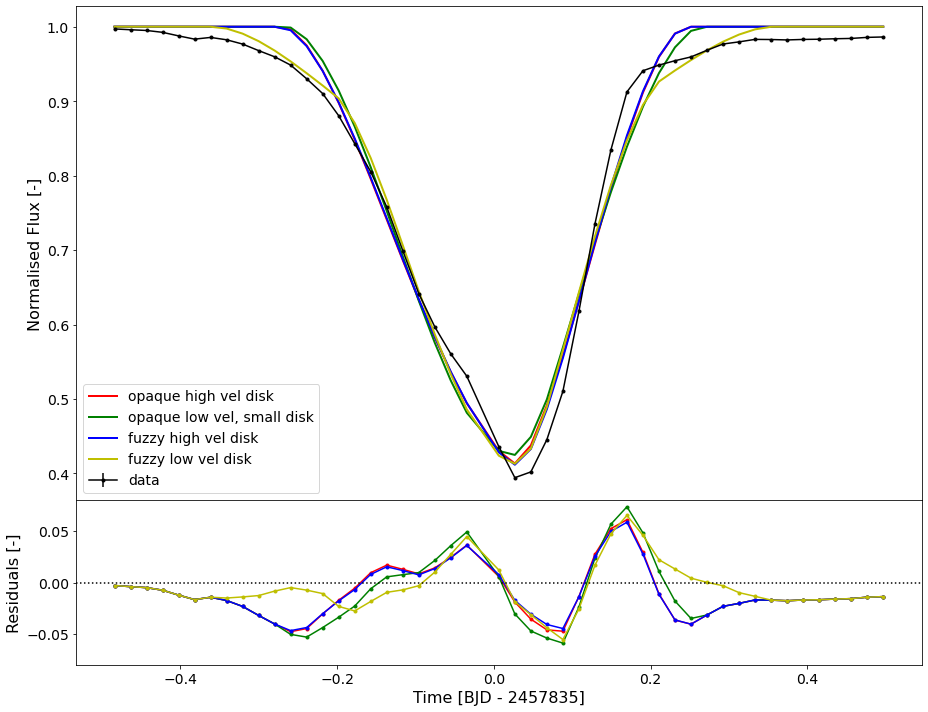

In [30]:
all_mods = 2 * [opaque_disk] + 2 * [fuzzy_disk]
all_lbls = ['opaque high vel disk', 'opaque low vel, small disk', 
            'fuzzy high vel disk', 'fuzzy low vel disk']
all_pbs  = [pb_hvel_od, pb_ldr_od, pb_hvel_fd, pb_lvel_fd]

all_chi2 = mcmc.plot_models(time, flux, error, all_mods, all_pbs, all_lbls, dt=3002, 
                            residual_lims=(-0.08, 0.08), lw=2)

In [31]:
all_disk  = 2 * ['opaque'] + 2 * ['fuzzy']
all_type  = ['high velocity', 'low velocity, small disk', 'high vel disk', 'low vel disk']
all_lbls  = 2 * [lbls_od] + 2 * [lbls_fd]
all_units = 2 * [units_od] + 2 * [units_fd]


for disk, typ, pb, chi2, lbl, unit in zip(all_disk, all_type, all_pbs, all_chi2, all_lbls, all_units):
    #print(disk, typ, pb, chi2, lbl, unit)
    print('%s disk with %s' % (disk, typ))
    mcmc.print_parameters(pb, lbl, unit)
    print('chi2 = %.2f' % chi2)
    print('')

opaque disk with high velocity
disk radius        =     +1.939238     [R*]
impact parameter   =     +0.851913     [R*]
inclination        =     +67.11369     [deg]
tilt               =     +24.83339     [deg]
velocity           =     +9.135350     [R*/day]
time shift         =     -0.058551     [day]
chi2 = 2682609.33

opaque disk with low velocity, small disk
disk radius        =     +0.992294     [R*]
impact parameter   =     -0.250570     [R*]
inclination        =     +56.78165     [deg]
tilt               =     +41.21967     [deg]
velocity           =     +6.636696     [R*/day]
time shift         =     +0.009899     [day]
chi2 = 3540913.90

fuzzy disk with high vel disk
disk radius        =     +2.226520     [R*]
edge thickness     =     +0.051511     [R*]
impact parameter   =     +0.828510     [R*]
inclination        =     +64.60101     [deg]
tilt               =     +41.13838     [deg]
velocity           =     +9.200504     [R*/day]
time shift         =     -0.058869     [day]
di

Here we also save the two fuzzy disk models.

## Create LaTeX Tables

Here we define a function that will output most of the values in the desired format for the table to be used in the paper.

In [32]:
def latex_table_data(stats):
    names = ['$R_d$ [$R_*$]', '$t_e$ [$R_*$]', 'b [$R_*$]', '$i$ [$^\circ$]', '$\phi$ [$^\circ$]', 
             '$v_t$ [$R_*\,\mathrm{day}^{-1}$]', '$v_{t,A}$ [$\mathrm{km s}^-1$]', 
             '$v_{t,B}$ [$\mathrm{km s}^-1$]', '$\delta t$ [$\mathrm{day}$]', '$\tau$ [-]', '%\tau_e$ [-]']
    rd = te = b = i = phi = vt = vta = vtb = dt = tau = taue = ''
    strs = [rd, te, b, i, phi, vt, vta, vtb, dt, tau, taue]
    for x, stat in enumerate(stats):
        s = np.zeros((11,3))
        if len(stat) == 6:
            s[[0,2,3,4,5,8],:] = stat
            s[9,0] = 1
            s[6,:] = stat[4,:]
            s[7,:] = stat[4,:]
        else:
            s[[0,1,2,3,4,5,8,9,10],:]=stat
            s[6,:] = stat[5,:]
            s[7,:] = stat[5,:]
        for j in range(len(s)):
            par = s[j,0]
            unc = np.amax(s[j,1:])
            if (j == 3) or (j == 4):
                par = np.rad2deg(par)
                unc = np.rad2deg(unc)
            if j == 6:
                par = ((par * 1.376*u.Rsun/u.day).to(u.km/u.s)).value
                unc = ((unc * 1.376*u.Rsun/u.day).to(u.km/u.s)).value
            if j == 7:
                par = ((par * 1.296*u.Rsun/u.day).to(u.km/u.s)).value
                unc = ((unc * 1.296*u.Rsun/u.day).to(u.km/u.s)).value
            if par == 0:
                strs[j] = strs[j] + '&   $-$   '
            else:
                strs[j] = strs[j] + '& %.4f $\pm$ %.4f ' % (par, unc)
    for j in range(len(strs)):
        strs[j] = '%s %s \\' % (names[j], strs[j])
        print(strs[j])
    return strs

In [35]:
tabdat = latex_table_data([stats_hvel_od, stats_ldr_od, stats_vh_fd, stats_vl_fd])

$R_d$ [$R_*$] & 1.9392 $\pm$ 0.0005 & 0.9923 $\pm$ 0.0005 & 2.2265 $\pm$ 0.0485 & 0.9900 $\pm$ 0.0004  \
$t_e$ [$R_*$] &   $-$   &   $-$   & 0.0515 $\pm$ 0.0515 & 1.7440 $\pm$ 0.0018  \
b [$R_*$] & 0.8519 $\pm$ 0.0007 & -0.2506 $\pm$ 0.0002 & 0.8285 $\pm$ 0.0022 & -0.3130 $\pm$ 0.0003  \
$i$ [$^\circ$] & 67.1137 $\pm$ 0.0141 & 56.7817 $\pm$ 0.0262 & 64.6010 $\pm$ 0.0319 & 59.9468 $\pm$ 0.0167  \
$\phi$ [$^\circ$] & 24.8334 $\pm$ 0.0195 & 41.2197 $\pm$ 0.0496 & 41.1384 $\pm$ 0.0830 & 38.8399 $\pm$ 0.0511  \
$v_t$ [$R_*\,\mathrm{day}^{-1}$] & 9.1354 $\pm$ 0.0013 & 6.6367 $\pm$ 0.0018 & 9.2005 $\pm$ 0.0066 & 8.3637 $\pm$ 0.0030  \
$v_{t,A}$ [$\mathrm{km s}^-1$] & 101.2166 $\pm$ 0.0149 & 73.5324 $\pm$ 0.0199 & 101.9385 $\pm$ 0.0729 & 92.6675 $\pm$ 0.0328  \
$v_{t,B}$ [$\mathrm{km s}^-1$] & 95.3319 $\pm$ 0.0140 & 69.2572 $\pm$ 0.0187 & 96.0119 $\pm$ 0.0687 & 87.2798 $\pm$ 0.0309  \
$\delta t$ [$\mathrm{day}$] & -0.0586 $\pm$ 0.0001 & 0.0099 $\pm$ 0.0000 & -0.0589 $\pm$ 0.0002 & 0.0164 $\pm$